In [48]:
import os
import re
import glob
import yaml
import warnings
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
pl.seed_everything(42)

from dataset import E33OMA
from model import STMLightning
from utils import qqplot, find_nearest

Seed set to 42


In [49]:
def natural_sort_key(s):
    # Split the string into segments of digits and non-digits
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

models_path_root = '/home/serfani/serfani_data1/snapshots'
# List directory contents
dir_contents = os.listdir(models_path_root)

# Sort using the custom sort key
sorted_contents = sorted(dir_contents, key=natural_sort_key)

# Print sorted contents
for idx, model in enumerate(sorted_contents):
    print(idx, model)

0 ConvLSTM-02102025-1714
1 LSTM-64K5.32K3.16K3-E33OMA90D-5C-BCB-20241014-1247
2 LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949
3 LSTM-64K5.32K3.16K3-E33OMA-8C-BCB-20240719-1241
4 SimVP-02122025-1148
5 SimVP-02132025-1532
6 UNet-E33OMA-5C-BCB-20240718-1527


In [50]:
model_index = 0
model_name  = sorted_contents[model_index]

save_figure = False

# Read the YAML/CKPT files
snapshot_dir = os.path.join(models_path_root, model_name)
config_filepath = glob.glob(os.path.join(snapshot_dir, "version_*", "hparams.yaml"))[0]
checkpoint_path = glob.glob(os.path.join(snapshot_dir, "version_*", "checkpoints", "*.ckpt"))[0]

with open(config_filepath, 'r') as config_filepath:
    hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

# Print dynamically created variables
for cat in ['model_args', 'data_args']:
    print(f'{cat}:')
    for key, value in hyperparams[cat].items():
        print(f'{key}: {value}')
    print()

model_args:
encoder_channels: [64, 32, 16]
epochs: 50
in_channels: 5
kernel_size: [7, 5, 3]
learning_rate: 0.001
log_dir: /home/serfani/serfani_data1/snapshots
model_name: ConvLSTM
out_channels: 1
weight_decay: 0.001

data_args:
batch_size: 8
data_name: E33OMA
num_workers: 4
padding: [5, 5]
sequence_length: 48
size: [90, 144]
species: bcb



### Load Dataset and Model

In [51]:
dataset = E33OMA(period='test', species=data_args['species'], padding=data_args['padding'], sequence_length=data_args['sequence_length'])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False) # , num_workers=4, pin_memory=True, persistent_workers=True)

In [52]:
net = STMLightning.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_args=model_args,
    data_args=data_args
)
net.eval()

STMLightning(
  (model): ConvLSTM(
    (layers): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(69, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (sigmoid): Sigmoid()
        (tanh): Tanh()
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (sigmoid): Sigmoid()
        (tanh): Tanh()
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (sigmoid): Sigmoid()
        (tanh): Tanh()
      )
    )
    (conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (loss1): MSELoss()
)

In [6]:
# Preallocation
total_samples = len(dataloader.dataset)
GTs = torch.empty((total_samples, 1, 1, 90, 144), dtype=torch.float32)
PDs = torch.empty((total_samples, 1, 1, 90, 144), dtype=torch.float32)

sample_index = 0
with torch.no_grad():
    for counter, (X, y) in enumerate(dataloader, 1):

        batch_size = X.shape[0]

        X = X.cuda(non_blocking=True)      
        y = y.cuda(non_blocking=True)

        p = net(X)
        p = p[..., 
                  data_args['padding'][0]:data_args['padding'][0]+data_args['size'][0], 
                  data_args['padding'][1]:data_args['padding'][1]+data_args['size'][1]]

        GTs[sample_index:sample_index+batch_size] = (y * dataset.y_std) + dataset.y_mean
        PDs[sample_index:sample_index+batch_size] = (p * dataset.y_std) + dataset.y_mean
        
        sample_index += batch_size

GTs = GTs.cpu().numpy()
PDs = PDs.cpu().numpy()

print(GTs.shape, PDs.shape)

(17473, 1, 1, 90, 144) (17473, 1, 1, 90, 144)


In [7]:
with open(os.path.join(snapshot_dir, 'test-results.npy'), mode = 'wb') as f:

    np.save(f, GTs)
    np.save(f, PDs)

In [53]:
with open(os.path.join(snapshot_dir, 'test-results.npy'), mode='rb') as f:
    
    GTs = np.load(f, allow_pickle=True)
    PDs = np.load(f, allow_pickle=True)

print(GTs.shape, PDs.shape)

(17473, 1, 1, 90, 144) (17473, 1, 1, 90, 144)


In [54]:
def r_squared_temporal(gts, pds):

    r_squared_temporal = np.empty((gts.shape[0]))
    pearsonr_temporal = np.empty((gts.shape[0]))
    mae_temporal = np.empty((gts.shape[0]))
    rmse_temporal = np.empty((gts.shape[0]))

    for i, gt in enumerate(gts):
        r_squared_temporal[i] = r2_score(gt.flatten(), pds[i].flatten())
        pearsonr_temporal[i], _ = pearsonr(gt.flatten(), pds[i].flatten())
        mae_temporal[i] = mean_absolute_error(gt.flatten(), pds[i].flatten())
        rmse_temporal[i] = np.sqrt(root_mean_squared_error(gt.flatten(), pds[i].flatten()))

    return pd.DataFrame({
        'r_squared': r_squared_temporal,
        'pearsonr': pearsonr_temporal,
        'mae': mae_temporal,
        'rmse': rmse_temporal
    })

In [60]:
df = r_squared_temporal(GTs, PDs)

In [55]:
r_squared_temporal(GTs, PDs).describe()

,r_squared,pearsonr,mae,rmse
count,17473.000000,17473.000000,17473.000000,17473.000000
mean,0.844473,0.928782,1.774035,3.331517
std,0.076151,0.036150,1.313097,1.637679
min,0.198409,0.736168,0.378640,1.213541
25%,0.803799,0.908913,0.749472,2.006167
50%,0.854616,0.934874,1.030700,2.698558
75%,0.899508,0.955803,2.816085,4.414269
max,0.988821,0.994992,6.501947,9.492503


In [9]:
r_squared_temporal(GTs, PDs).describe()

,r_squared,pearsonr,mae,rmse
count,17473.000000,17473.000000,17473.000000,17473.000000
mean,0.814021,0.912387,2.153934,3.555586
std,0.097595,0.043642,1.514562,1.901587
min,-0.454744,0.632317,0.630738,1.251720
25%,0.772711,0.891114,0.972206,2.018903
50%,0.831697,0.920718,1.272838,2.740820
75%,0.879844,0.943507,3.317684,4.845944
max,0.992194,0.996320,7.396048,10.206220


In [11]:
def scatter_plot(ax, X, y, scale='linear'):

    idx = np.arange(len(X.ravel()))

    rng = np.random.default_rng(0)
    rng.shuffle(idx)

    v1 = X.ravel()[idx[:10000]]
    v2 = y.ravel()[idx[:10000]]

    max_value = np.array((v1, v2)).max()

    ax.scatter(v1, v2, color='teal', edgecolor='steelblue', alpha=0.5)
    ax.plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)

    ax.set_xlabel('Ground Truth')
    ax.set_xscale(scale)

    ax.set_ylabel('Prediction')
    ax.set_yscale(scale)

    ax.grid()

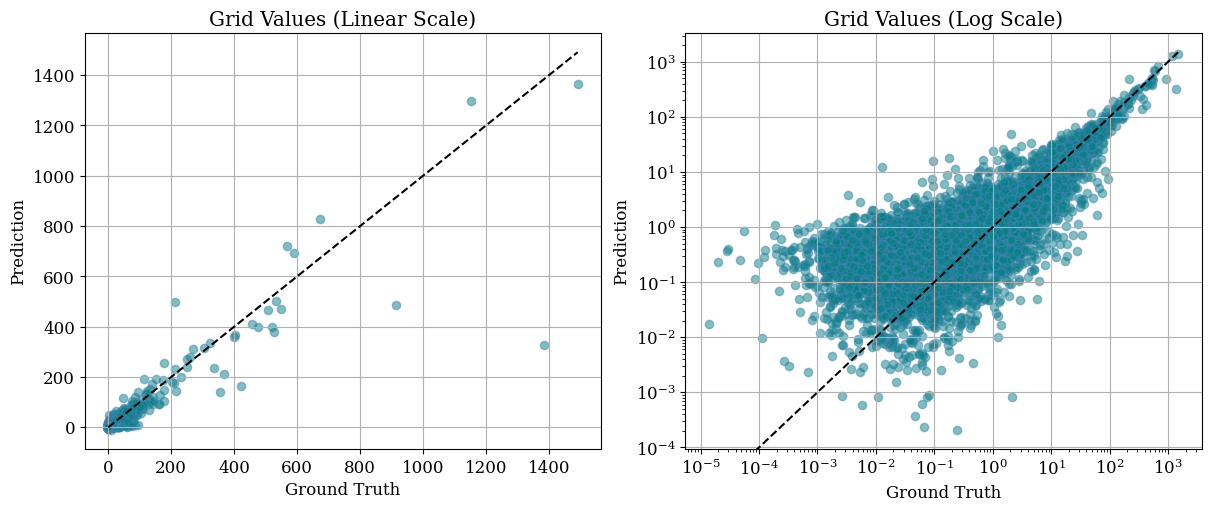

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), constrained_layout=True)

ax1.set_title('Grid Values (Linear Scale)')
scatter_plot(ax1, GTs, PDs, scale='linear')

ax2.set_title('Grid Values (Log Scale)')
scatter_plot(ax2, GTs, PDs, scale='log')

plt.show()

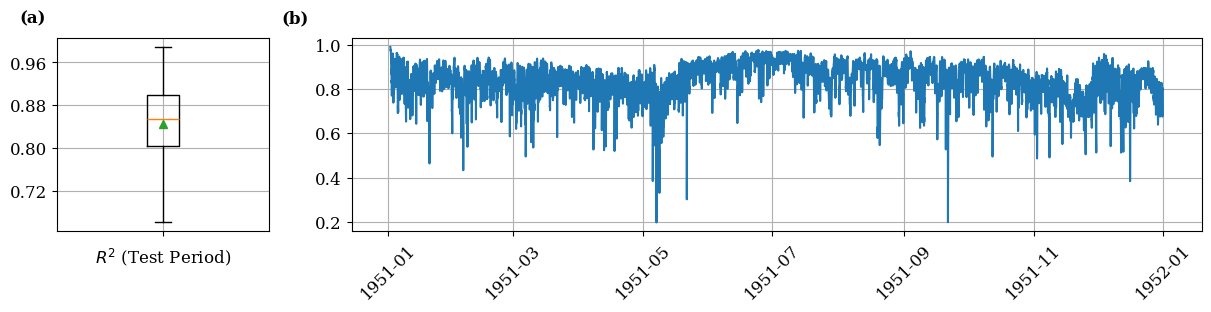

In [63]:
from matplotlib.ticker import MaxNLocator

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

v3 = r_squared_temporal(GTs, PDs)['r_squared'].values
time = dataset.datetimeindex[:]

ax2.boxplot(v3, showmeans=True, showfliers=False)
ax2.set_xticklabels([])
ax2.set_xlabel(r'$R^2$ (Test Period)')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6)) 
ax2.text(-0.05, 1.15, '(a)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax2.grid()

ax3.plot(time, v3)
ax3.tick_params(axis='x', labelrotation=45)
ax3.text(-0.05, 1.15, '(b)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax3.grid()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '01-r2_temporal_test.png'))

plt.show()

In [64]:
# Define the r_squared_spatial function
def r_squared_spatial(real_data, model_output):
    # Calculate the coefficient of determination (R^2)
    ss_res = np.sum((real_data - model_output) ** 2, axis=0)
    ss_tot = np.sum((real_data - np.mean(real_data, axis=0)) ** 2, axis=0)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [65]:
sr2 = r_squared_spatial(GTs.squeeze(), PDs.squeeze())
GTs = GTs * 0.01 # Convert from kg/kg to microgram/kg
PDs = PDs * 0.01

In [66]:
ds = xr.Dataset({
    'Real Data': (["time", "lat", "lon"], GTs.squeeze()),
    'Model Output': (["time", "lat", "lon"], PDs.squeeze()),
    'Coefficient of Determination': (["lat", "lon"], sr2),

              },
              
     coords=dict(
        time = dataset.datetimeindex,
        lon  = dataset.lon,
        lat  = dataset.lat,
    )
)

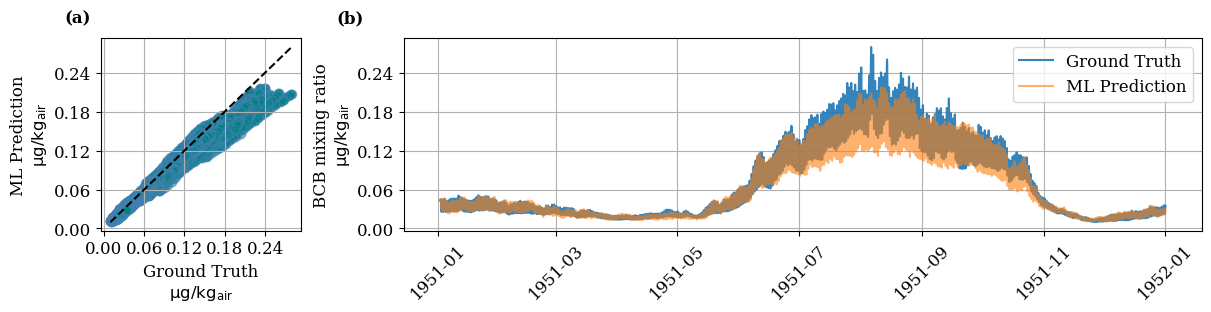

In [44]:
fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))

avgGT = ds_avg['Real Data'].values
avgPD = ds_avg['Model Output'].values

max_value = np.array((avgGT, avgPD)).max()
min_value = np.array((avgGT, avgPD)).min()

ax1.scatter(avgGT.ravel(), avgPD.ravel(), color='teal', edgecolor='steelblue', alpha=0.5)
ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

ax1.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax1.xaxis.set_major_locator(MaxNLocator(nbins=5)) 

# BCB mixing ratio
ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)
ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)

ax1.text(-0.05, 1.15, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax1.grid()

ax3.plot(dataset.datetimeindex, avgGT, alpha=0.9, label='Ground Truth')
ax3.plot(dataset.datetimeindex, avgPD, alpha=0.6, label='ML Prediction')

ax3.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax3.set_ylabel(r'BCB mixing ratio' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)
ax3.tick_params(axis='x', labelrotation=45)

ax3.text(-0.05, 1.15, '(b)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax3.grid()

plt.legend()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '02-global_average.png'))

plt.show()

### Exceedence Probability

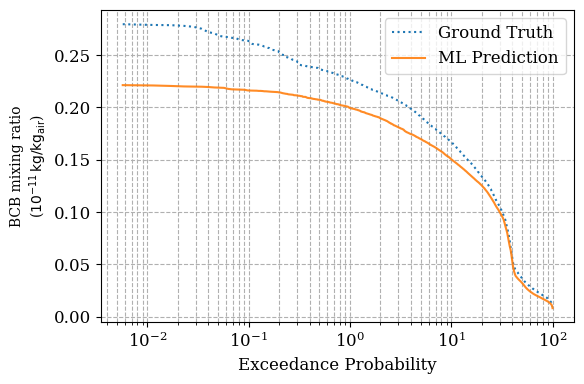

In [24]:
def exceedence_probability(values):
    v = np.array(values)  # Convert to numpy array
    v = -np.sort(-v)  # Sort in descending order
    ep = 100 * np.arange(1, len(v) + 1) / (len(v) + 1)  # Weibull formula
    return v, ep

v1, ep1 = exceedence_probability(avgGT)
v2, ep2 = exceedence_probability(avgPD)

# In case interpolation is needed
# np.interp(0.05, weibull_exceedance_probability, sorted_flow)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the exceedance probabilities
ax.plot(ep1, v1, ':', alpha=1.0, label='Ground Truth')
ax.plot(ep2, v2, '-', alpha=0.9, label='ML Prediction')

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Add labels and title
ax.set_ylabel(r'BCB mixing ratio' '\n' r'($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=10)
ax.set_xlabel('Exceedance Probability')

# Add grid, legend, and show the plot
ax.grid(True, which="both", ls="--")
ax.legend()
plt.tight_layout()
plt.show()

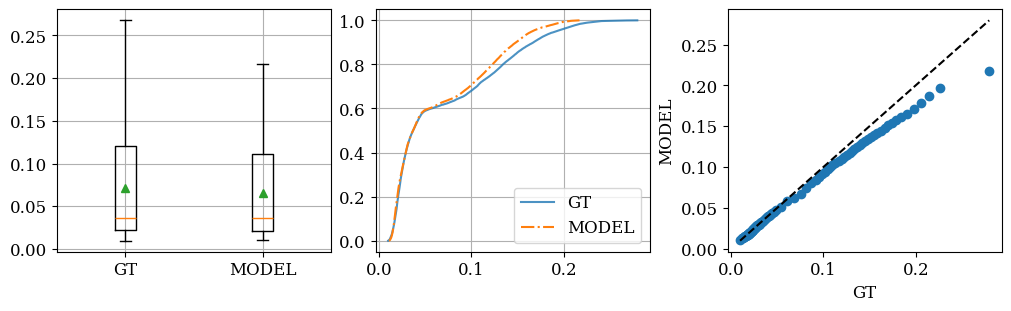

In [45]:
qqplot(avgGT.ravel(), avgPD.ravel(), yax1='' ,axis_names=None, quantiles=100, save_figure=False, fformat=None, saving_path=None)

In [67]:
import geopandas as gpd
from cartopy import crs as ccrs

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

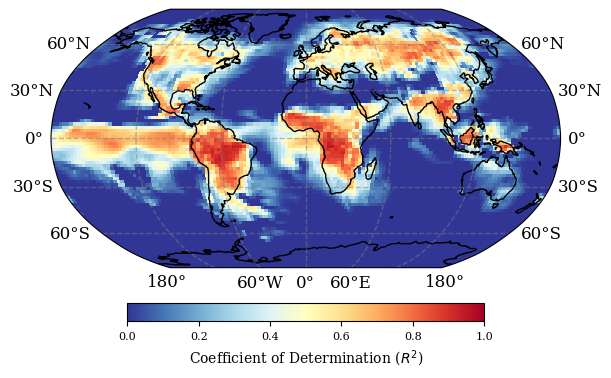

In [68]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)


ax.coastlines()

# Get the data for the current level
data = ds['Coefficient of Determination']

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im = ax.pcolormesh(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    vmin=0.0, vmax=1.0,
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Coefficient of Determination ($R^2$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '03-r2_spatial_test.png'))

plt.show()

In [21]:
df = ds.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
gdf = df.groupby(['lat', 'lon'])
df.head()

,lat,lon,time,Real Data,Model Output,Coefficient of Determination
0,-90.0,-178.75,1951-01-01 23:45:00,0.000001,0.000024,-2348.021729
1,-90.0,-178.75,1951-01-02 00:15:00,0.000001,0.000037,-2348.021729
2,-90.0,-178.75,1951-01-02 00:45:00,0.000001,0.000065,-2348.021729
3,-90.0,-178.75,1951-01-02 01:15:00,0.000001,0.000053,-2348.021729
4,-90.0,-178.75,1951-01-02 01:45:00,0.000001,0.000045,-2348.021729


In [22]:
def plot_on_grid(gdf, lat, lon, fig_num):

    from matplotlib import rcParams
    from matplotlib.ticker import MaxNLocator
    rcParams['font.size'] = 10  # Set the default font size

    g = gdf.get_group((lat, lon))
    g = g.sort_values('time')

    r2 = g['Coefficient of Determination'].iloc[0]
    print(f'exact coordinates, lat:{lat}, lon:{lon}, R2H: {r2:.2f}')
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    # Rename columns directly in the plot command
    ax.plot(g['time'], g['Real Data'], label='Ground Truth', alpha=1.0)
    ax.plot(g['time'], g['Model Output'], label='ML Prediction', alpha=0.6)
    
    # Set x-ticks to display month names
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45)

    ax.set_ylabel(r'BCB mixing ratio' '\n' r'($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 

    ax.text(-0.05, 1.08, f'({fig_num})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    
    # Adjust the font size of the legend
    ax.legend(fontsize=12, loc=2)  # Set the desired font size for the legend

    ax.grid(True)

    # plt.savefig(f'fig05-{fig_num}.svg')
    plt.show()

exact coordinates, lat:-75.0, lon:-51.25, R2H: -239.68


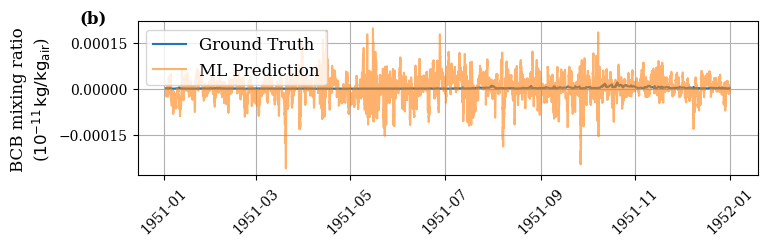

In [23]:
lat, lon = find_nearest(df[['lat', 'lon']], -75, -50)
plot_on_grid(gdf, lat, lon, 'b')

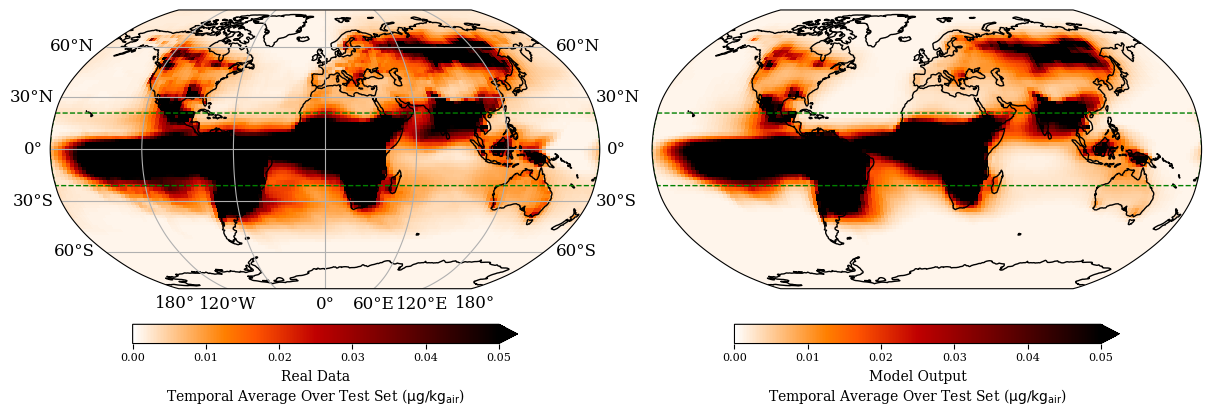

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)


ax1.coastlines()

# Get the data for the current level
data1 = ds['Real Data'].mean(dim='time').clip(min=1E-3)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im1 = ax1.pcolormesh(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    cmap='gist_heat_r',
    vmin=0.0, vmax=0.05
)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl1.top_labels = False

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.7, extend='max')
cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here


ax2.coastlines()

# Get the data for the current level
data2 = ds['Model Output'].mean(dim='time').clip(min=1E-3)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im2 = ax2.pcolormesh(
    lon, lat, data2,
    transform=ccrs.PlateCarree(),
    cmap='gist_heat_r',
    vmin=0, vmax=0.05
)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.02, shrink=0.7, extend='max')
cbar.set_label('Model Output' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

# Create separate patches for each set of axes
tropical_zone1 = patches.Rectangle((-180, -21), 360, 42, linewidth=1, edgecolor='green', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
tropical_zone2 = patches.Rectangle((-180, -21), 360, 42, linewidth=1, edgecolor='green', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())

ax1.add_patch(tropical_zone1)
ax2.add_patch(tropical_zone2)

# northern_mid_latitude_zone = patches.Rectangle((-180, 21), 360, 40, linewidth=1, edgecolor='blue', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
# ax1.add_patch(northern_mid_latitude_zone)

plt.show()

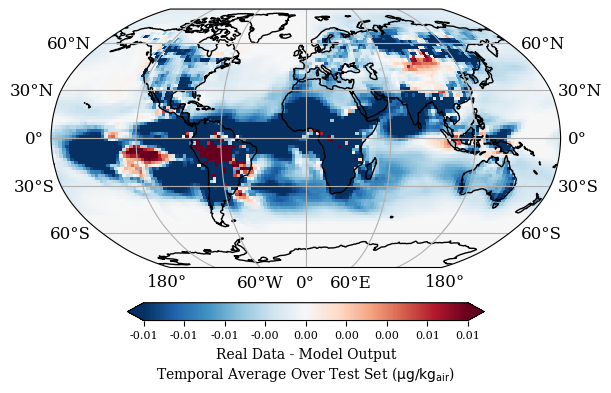

In [70]:
from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)


ax1.coastlines()

# Get the data for the current level
data = data2 - data1

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im1 = ax1.pcolormesh(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-0.01, vmax=0.01
)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl1.top_labels = False

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.7, extend='both')
cbar.set_label('Real Data - Model Output' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

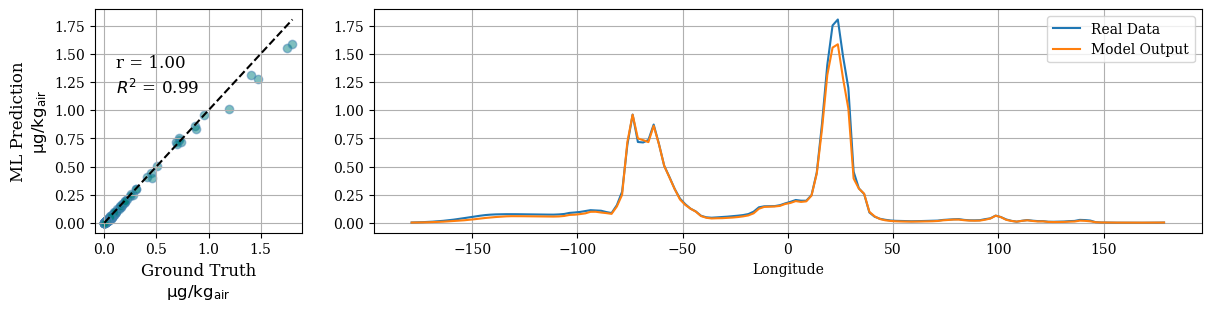

In [32]:

from sklearn.metrics import r2_score


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})


# roi = 'Northern Mid-Latitude Zone'
roi = 'Tropical Zone'

if roi == 'Northern Mid-Latitude Zone':
    ds_roi = ds.mean(dim=("time")).sel(lat=slice(21, 61))

elif roi == 'Tropical Zone':
    ds_roi = ds.mean(dim=("time")).sel(lat=slice(-21, 21))

weights = np.cos(np.deg2rad(ds_roi.lat))
weights.name = "weights"

avgGT = ds_roi['Real Data'].weighted(weights).mean(dim=("lat"))
avgPD = ds_roi['Model Output'].weighted(weights).mean(dim=("lat"))

corr, _ = pearsonr(avgGT.values, avgPD.values)
nse = r2_score(avgGT.values, avgPD.values)

ax1.text(0.1, 0.80, rf'r = {corr:.2f}', transform=ax1.transAxes, fontsize=12, va='top', ha='left')
ax1.text(0.1, 0.70, rf'$R^2$ = {nse:.2f}', transform=ax1.transAxes, fontsize=12, va='top', ha='left')

max_value = np.array((avgGT, avgPD)).max()
min_value = np.array((avgGT, avgPD)).min()

ax1.scatter(avgGT.values, avgPD.values, color='teal', edgecolor='steelblue', alpha=0.5)
ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)
ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)

ax1.grid()

avgGT.plot(ax=ax2, label='Real Data')
avgPD.plot(ax=ax2, label='Model Output')

ax2.set_xlabel('Longitude')
ax2.set_ylabel(' ')

ax2.legend()
ax2.grid()

plt.show()